<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_02_T_01/HW_02_T_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [2]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data info for all dataset
(99999, 2)
(99999,)
[-1.91759247 -0.12925264]
2


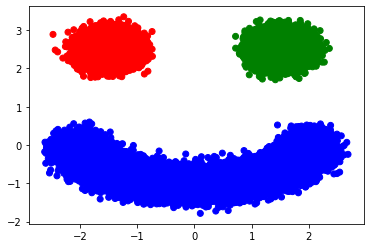

In [9]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

def print_data_info(X, y, label):
    print(f'Data info for {label}')
    print(X.shape)
    print(y.shape)
    print(X[1])
    print(y[1])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
    plt.show()
  
X, Y = sample_data()
print_data_info(X, Y, 'all dataset')

Data info for train
torch.Size([79999, 2])
torch.Size([79999])
tensor([-1.8588, -0.3814])
tensor(2.)


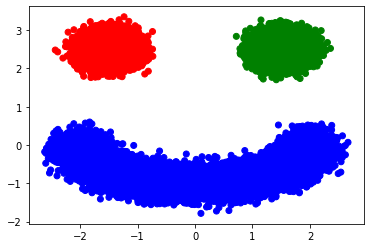

Data info for test
torch.Size([20000, 2])
torch.Size([20000])
tensor([ 1.5242, -0.3453])
tensor(2.)


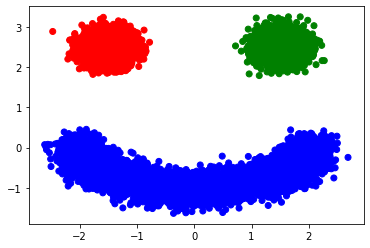

In [22]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=SEED)
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = torch.FloatTensor(X_TRAIN), torch.FloatTensor(X_TEST), torch.FloatTensor(Y_TRAIN), torch.FloatTensor(Y_TEST)
print_data_info(X_TRAIN, Y_TRAIN, 'train')
print_data_info(X_TEST, Y_TEST, 'test')

In [42]:
X_Y_TRAIN = torch.cat((X_TRAIN, Y_TRAIN.unsqueeze(1)), dim=1)
X_Y_TEST = torch.cat((X_TEST, Y_TEST.unsqueeze(1)), dim=1)
print(X_Y_TRAIN.shape)
print(X_Y_TEST.shape)

torch.Size([79999, 3])
torch.Size([20000, 3])


In [0]:
class flow(nn.Module):
    def __init__(self, k):
        super(flow,self).__init__()
        self.k = k
        
        #layers
        self.layers = nn.Sequential(
            nn.Linear(1,100),
            nn.Tanh()
        )
        
        self.network = nn.Sequential(*self.layers)
        self.pi = nn.Linear(100, self.k)
        self.mu = nn.Linear(100, self.k)
        self.sigma = nn.Linear(100, self.k)

        
    def forward(self,x):
        x = self.network(x)
        pi = F.softmax(self.pi(x), dim=-1).view(-1, self.k)
        mu = self.mu(x).view(-1, self.k)
        sigma = torch.exp(self.sigma(x).view(-1, self.k))
        
        return pi, mu, sigma

In [0]:
class mycdf(nn.Module):
  
    def __init__(self, k):
    
      super(mycdf, self).__init__()
      self.k = k
      self.batch = 0
      self.pi = nn.Parameter(torch.randn(self.k, requires_grad=True))
      self.mu = nn.Parameter(torch.randn(self.k, requires_grad=True))
      self.sigma = nn.Parameter(torch.randn(self.k, requires_grad=True))
      
      self.fx2x1 = flow(self.k)
      
    def x_split(self,x):
      x1, x2 = x[:, 0],x[:, 1]
      self.batch = x1.shape[0]
      
      x1 = x1.reshape(-1, 1)
      x2 = x2.reshape(-1, 1)
      return x1, x2
    
    def pi_mu_sigma(self, x):
      x1, x2 = self.x_split(x)

      pi1, mu1, sigma1 = F.softmax(self.pi.repeat(self.batch, 1)), self.mu.repeat(self.batch, 1), torch.exp(self.sigma.repeat(self.batch, 1))
      pi2, mu2, sigma2 = self.fx2x1.forward(x1)
      
      return (pi1, mu1, sigma1, pi2, mu2, sigma2)
    
    def f(self,x):
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.pi_mu_sigma(x)
      
      z1 = torch.zeros(self.batch,1)
      z2 = torch.zeros(self.batch,1)
      
      x1, x2 = self.x_split(x)
      
      for i in range(self.k):
        z1 += pi1[:, i:i + 1] * (Normal(mu1[:, i:i+1].float(),(sigma1[:, i:i+1]).float()).cdf(x1))
        z2 += pi2[:, i:i + 1] * (Normal(mu2[:, i:i+1].float(),(sigma2[:, i:i+1]).float()).cdf(x2))
      return z1,z2
    
    def probs(self,x):
      pi1, mu1, sigma1, pi2, mu2, sigma2 = self.pi_mu_sigma(x)      
      
      prob_x1 = torch.zeros(self.batch, 1)
      prob_x2 = torch.zeros(self.batch, 1)
      
      x1, x2 = self.x_split(x)
      
      for i in range(self.k):
        prob_x1 += pi1[:,i:i+1] * (Normal(mu1[:,i:i+1].float(), (sigma1[:,i:i+1]).float()).log_prob(x1).exp())  # TODO: * (mu - x) / sigma^2 ?
        prob_x2 += pi2[:,i:i+1] * (Normal(mu2[:,i:i+1].float(), (sigma2[:,i:i+1]).float()).log_prob(x2).exp())
        
      return prob_x1 * prob_x2
    
    def loss(self,x):
      return torch.mean(-torch.log(self.probs(x))/np.log(2))/2

In [0]:
def train(model, train_batch_size, test_batch_size, epochs_cnt):
    train_iter = torch.utils.data.DataLoader(X_Y_TRAIN, batch_size=train_batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(X_Y_TEST, batch_size=test_batch_size, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    losses, val_losses = [], []
    for epoch in range(epochs_cnt):
        loss = 0
        tmp_losses = []
        
        model.train()
        total_train_loss = 0
        for item in train_iter:
            X_batch, y_batch = item[:, :2], item[:, 2]
            loss = model.loss(X_batch)
            loss.backward()    
            optimizer.step()
            optimizer.zero_grad()
            tmp_losses.append(loss.data.numpy())
        losses.append(np.mean(tmp_losses))
        
        model.eval()
        with torch.no_grad():
            tmp_val_losses = []
            for item in val_iter:
                X_batch, y_batch = item[:, :2], item[:, 2]
                val_loss = model.loss(X_batch)
                tmp_val_losses.append(val_loss.data.numpy())
            val_losses.append(np.mean(tmp_val_losses))
        if epoch % 1 ==0:
            print('Epoch {}: loss {} val_loss {} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))
    return losses, val_losses    

In [0]:
def plot_losses(losses, val_losses):
  plt.plot(losses, label = "train_loss")
  plt.plot(val_losses, label = "val_loss")
  plt.legend()
  plt.show()

In [0]:
K = 6
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
EPOCHS_CNT = 25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 2.132634401321411 val_loss 1.6783205270767212 
Epoch 1: loss 1.4742777347564697 val_loss 1.3427059650421143 
Epoch 2: loss 1.249993920326233 val_loss 1.181787371635437 
Epoch 3: loss 1.1321462392807007 val_loss 1.103877305984497 
Epoch 4: loss 1.0661120414733887 val_loss 1.048817753791809 
Epoch 5: loss 1.029690146446228 val_loss 1.0247081518173218 
Epoch 6: loss 1.0095120668411255 val_loss 1.0124799013137817 
Epoch 7: loss 0.9991486072540283 val_loss 1.002625584602356 
Epoch 8: loss 0.9923784732818604 val_loss 1.0027869939804077 
Epoch 9: loss 0.987490713596344 val_loss 0.9920615553855896 
Epoch 10: loss 0.9820404648780823 val_loss 0.9868984222412109 
Epoch 11: loss 0.9796581268310547 val_loss 0.9831538200378418 
Epoch 12: loss 0.9787212610244751 val_loss 0.9852433204650879 
Epoch 13: loss 0.9778017401695251 val_loss 0.9877393841743469 
Epoch 14: loss 0.9750756025314331 val_loss 0.9879794716835022 
Epoch 15: loss 0.9753078818321228 val_loss 0.9789506196975708 
Epoch 16: 

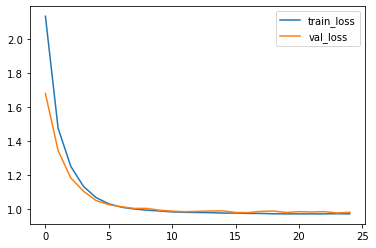

In [142]:
model = mycdf(K)
TRAIN_LOSSES, VAL_LOSSES = train(model, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, EPOCHS_CNT)
plot_losses(TRAIN_LOSSES, VAL_LOSSES)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([80, 80])


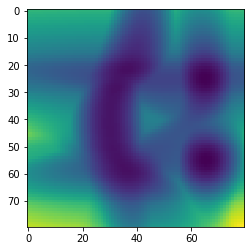

In [152]:
def draw_samples(model):
    space = np.arange(-4, 4, 0.1)
    grid = torch.zeros((len(space) ** 2, 2))
    probs = torch.zeros(len(space), len(space))
    ind = 0
    for i in range(len(space)):
        for j in range(len(space)):
            x1 = space[i]
            x2 = space[j]
            loss = model.loss(torch.FloatTensor([[x1, x2]]))
            probs[i][j] = loss.data.item()
    print(probs.shape)
    plt.imshow(probs)
    plt.show
draw_samples(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


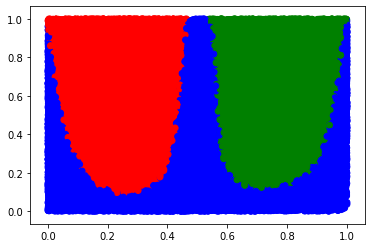

In [157]:
def draw_latent_space(model):
    z1, z2 = model.f(X_TRAIN)
    plt.scatter(z1[:, 0].detach().numpy(), z2[:, 0].detach().numpy(), c=Y_TRAIN, cmap=matplotlib.colors.ListedColormap(['red','green','blue']))
    plt.show()

draw_latent_space(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


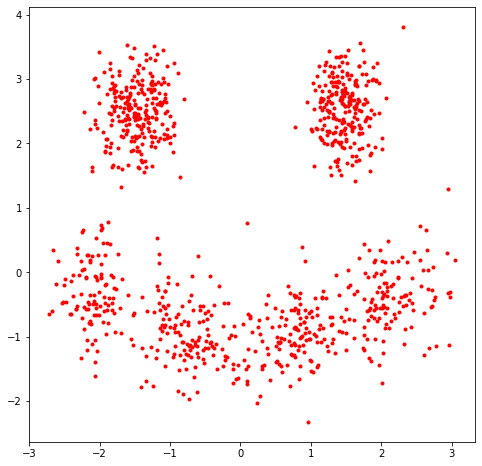

In [166]:
def sample_preds(pi, sigmasq, mu, samples=1000):
  # rather than sample the single conditional mode at each
  # point, we could sample many points from the GMM produced
  # by the model for each point, yielding a dense set of
  # predictions
  N, K = pi.shape
  _, KT = mu.shape
  T = int(KT / K)
  out = Variable(torch.zeros(N, samples, T))  # s samples per example
  for i in range(N):
    for j in range(samples):
      # pi must sum to 1, thus we can sample from a uniform
      # distribution, then transform that to select the component
      u = np.random.uniform()  # sample from [0, 1)
      # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
      # then determine the segment `u` that falls into and sample from that component
      prob_sum = 0
      for k in range(K):
        prob_sum += pi.data[i, k]
        if u < prob_sum:
          # sample from the kth component
          for t in range(T):
            sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
            out[i, j, t] = sample
          break
  return out

def display_samples(model):
    pi1 = F.softmax(model.pi).view(1,-1)
    mu1 = model.mu.view(1,-1)
    sigma1 = torch.exp(model.sigma).view(1,-1)
    preds_x1 = sample_preds(pi1, sigma1, mu1, samples=1000)
    pi2, mu2, sigma2 = model.fx2x1(preds_x1)
    preds_x2 = sample_preds(pi2, sigma2, mu2, samples=1)
    fig = plt.figure(figsize=(8,8))
    for i in range(preds_x2.shape[0]):
      plt.plot(preds_x1.squeeze(0).detach().numpy()[i], preds_x2.squeeze(1).numpy()[i], 'r.')
    plt.show()

display_samples(model)